In [2]:
###################################################################################################################
#This cell is for the purpose to import all libraries this project will use.
###################################################################################################################

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
import time
import pickle as pk
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque
%matplotlib inline

c:\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


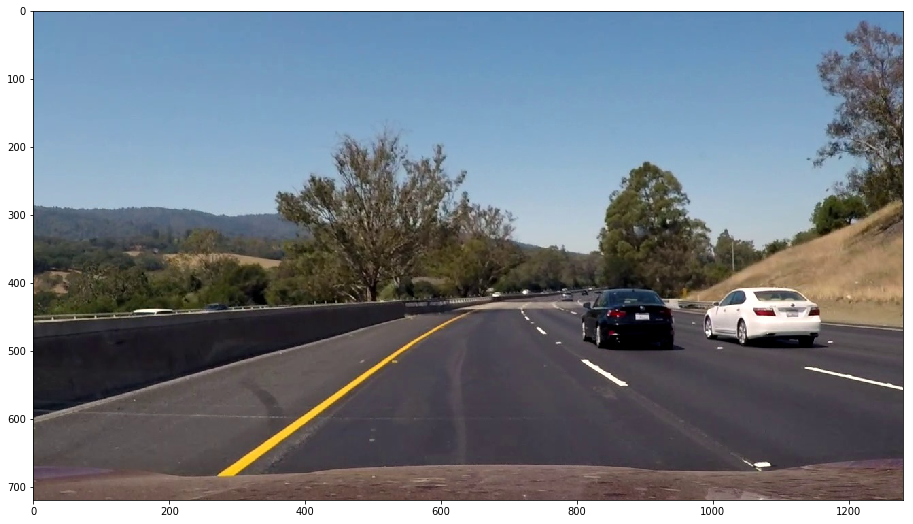

In [3]:
###################################################################################################################
#This function will be used to show some result figures in jupyter notebook codeline.
###################################################################################################################

def subplot(rows, cols, imgs):
    nums = rows * cols
    if len(imgs) > nums:
        print('No enough space for drawing figures!')
        return
    else:
        fig = plt.figure(1, figsize=(16, 9))
        for i in range(1, nums+1):
            plt.subplot(rows, cols, i)
            plt.imshow(imgs[i-1])
            
show_image = []
test_image = mpimg.imread('test.jpg')
show_image.append(test_image)
subplot(1, 1, show_image)

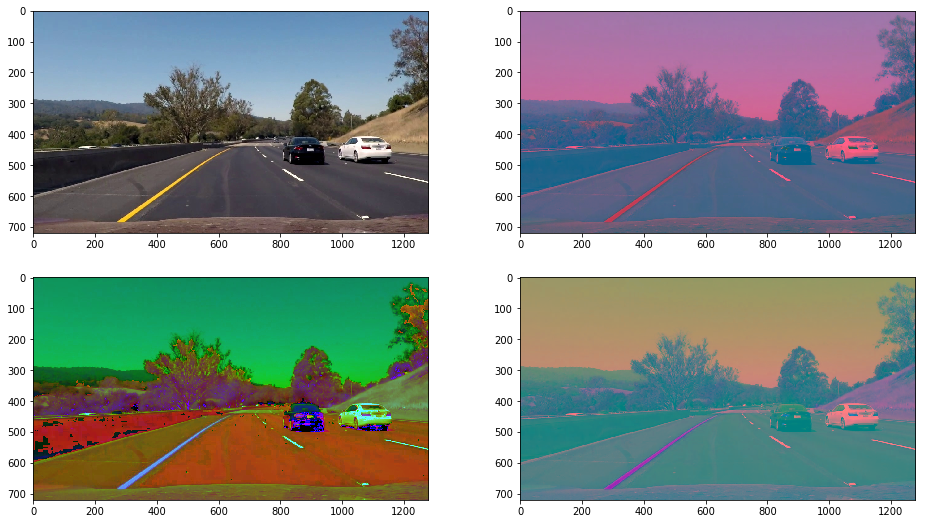

In [4]:
###################################################################################################################
#This function will be used to convert an input image to the parameter 'color_space' specified color space image.
#Optional color space includes 'BGR' 'RGB' 'HSV' 'LUV' 'HLS' 'YUV' 'LAB' 'YCrCb'
###################################################################################################################

def color_space_convert(img, color_space="BGR"):
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'LAB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif color_space == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else:
        feature_image = np.copy(img)
    #return the converted image as the result
    return feature_image

show_image = []
test_image = mpimg.imread('test.jpg')
test_image2 = color_space_convert(test_image, color_space="LUV")
test_image3 = color_space_convert(test_image, color_space="HLS")
test_image4 = color_space_convert(test_image, color_space="YCrCb")
show_image.append(test_image)
show_image.append(test_image2)
show_image.append(test_image3)
show_image.append(test_image4)
subplot(2, 2, show_image)

In [5]:
###################################################################################################################
#This function resizes an input image into the parameter 'size' specified size, and then flatten it into 1-D.
#The 1-D array will be returned as this image's binning spatial features.
###################################################################################################################

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

test_image = cv2.imread('test.jpg')
test_image_bin_spatial_features = bin_spatial(test_image, size=(8, 8))
print(test_image_bin_spatial_features)

[189 152 113 188 150 110 187 146 107 188 146 103 189 147 102 188 145 102
 188 146 102 123 106  91 196 164 129 197 165 126 197 163 124 198 164 125
 195 159 121 198 162 124 194 162 123  99  86  79 203 180 149 202 180 145
 205 179 144 155 138 126 203 181 145 203 180 145 205 180 150 198 178 148
  98  88  78 110  95  82  63  71  69  46  60  57 214 201 184  33  52  56
 204 196 179  29  47  61  49  67  74  15  23  22  38  66  77  15  27  29
  27  33  32  31  29  28  70 101 126 104 140 173  32  22  28  33  28  30
 106 107 117  73  85 109  80  72  77   0   0   0  82  78  84  72  72  79
 110 117 128  83  85  92  77  80  86  74  70  76  74  65  69  73  66  71
  79  69  76  73  63  68  92  80  96  70  70  76  61  58  64 106 112 135
 105 109 132 103 105 123  65  62  73  73  73 100]


In [6]:
###################################################################################################################
#This function calculates an input image's color histogram specified by parameters 'nbins' and 'bins_range', and 
#return the flatten color histogram of all channels as the hist features.
###################################################################################################################

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range, normed=False)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range, normed=False)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range, normed=False)
    #Concatenate all channels into one 1-D array.
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

test_image = cv2.imread('test.jpg')
test_image_color_hist_features = color_hist(test_image, nbins=16, bins_range=(0, 256))
print(test_image_color_hist_features)

[ 15228  44013  70618  47694 184510 122327  42297  24035  10237   7108
   6021 114930 198656  29743   1905   2278  10437  41049  36196  97429
 172685 108728  41080  23632  48970 133003 100853  79309  21843   1573
   1405   3408   9598  33276  36731  52293 168967 117995 155088 124867
  87879  61590  41697  17332   4553   1219   1607   6908]


[9.15989002 6.84101956 5.52439624 ... 0.39034175 0.31903866 0.09322624]


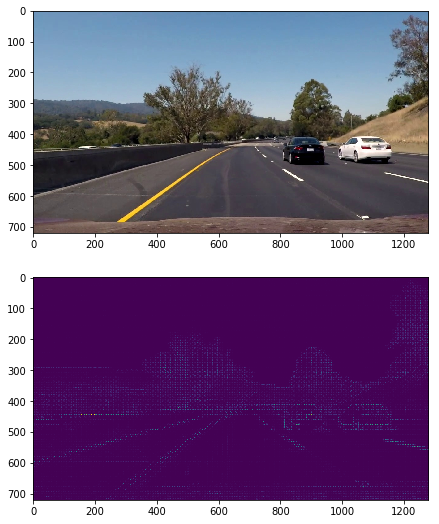

In [7]:
###################################################################################################################
#This function calculates the histogram of oriented gradients of an input image (2-D array) by using 
#skimage.feature.hog(), and return the flatten or not flatten hog features as the hog features. 
#Visualizing the HOG image is optional.
###################################################################################################################

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm='L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm='L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features
    
show_image = []
test_image = mpimg.imread('test.jpg')
show_image.append(test_image)
test_image_hog_features, HOG_image = get_hog_features(test_image[:, :, 1], orient=9, pix_per_cell=8,
                                                      cell_per_block=2, vis=True, feature_vec=True)
show_image.append(HOG_image)
print(test_image_hog_features)
subplot(2, 1, show_image)

In [7]:
###################################################################################################################
#This function receives an image-file-name-list as the input, and then perform the following process:
#1. Read in image files in image-file-name-list one by one.
#2. Convert the read in image to the specified color space.
#3. Extract flatten HOG features of all channels of the read in image.(optional)
#4. Extract flatten bin spatial features of the read in image.(optional)
#5. Extract flatten color hist features of the read in image.(optional)
#6. Concatenates all features into an 1-D array.
#7. Append all feature arrays into one list and return it as the result.
###################################################################################################################

def features_extract(imgs, color_space='BGR', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features_list = []
    #1. Read in an image file in image-file-name-list.
    for file in imgs:
        sample_features = []
        img = cv2.imread(file)
        #2. Convert the read in image to the specified color space.
        feature_image = color_space_convert(img, color_space=color_space)
        #3. Extract flatten HOG features of all channels of the read in image.(optional)
        if hog_feat == True:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                    orient, pix_per_cell, cell_per_block,
                                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
            sample_features.append(hog_features)
        #4. Extract flatten bin spatial features of the read in image.(optional)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            sample_features.append(spatial_features)
        #5. Extract flatten color hist features of the read in image.(optional)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            sample_features.append(hist_features)
        #6. Concatenates all features into an 1-D array.
        features_list.append(np.concatenate(sample_features))
    #7. Append all feature arrays into one list and return it as the result.
    return features_list

In [8]:
###################################################################################################################
#This function defines a nerual network to perform binary classification.
#The architecture of this network contains 4 layers, all are full-connect layers.
#L2 regularization and dropout are employed to fight with overfitting.
###################################################################################################################

def inference(input_tensor, regularizer, training=False):
    #layer 1: full-connect layer with shape (x_shape, fc1_out), using L2 regularization and dropout(50%).
    with tf.variable_scope('layer1-fc1'):
        fc1_weights = tf.get_variable('weight', [x_shape, fc1_out],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc1_weights))
        fc1_biases = tf.get_variable('bias', [fc1_out], initializer=tf.constant_initializer(0.0))
        fc1 = tf.nn.relu(tf.matmul(input_tensor, fc1_weights) + fc1_biases)
        if training:
            fc1 = tf.nn.dropout(fc1, 0.5)
            
    #layer 2: full-connect layer with shape (fc1_out, fc2_out), using L2 regularization and dropout(50%).
    with tf.variable_scope('layer2-fc2'):
        fc2_weights = tf.get_variable('weight', [fc1_out, fc2_out],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc2_weights))
        fc2_biases = tf.get_variable('bias', [fc2_out], initializer=tf.constant_initializer(0.0))
        fc2 = tf.nn.relu(tf.matmul(fc1, fc2_weights) + fc2_biases)
        if training:
            fc2 = tf.nn.dropout(fc2, 0.5)

    #layer 3: full-connect layer with shape (fc2_out, fc3_out), using L2 regularization and dropout(50%).
    with tf.variable_scope('layer3-fc3'):
        fc3_weights = tf.get_variable('weight', [fc2_out, fc3_out],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc3_weights))
        fc3_biases = tf.get_variable('bias', [fc3_out], initializer=tf.constant_initializer(0.0))
        fc3 = tf.nn.relu(tf.matmul(fc2, fc3_weights) + fc3_biases)
        if training:
            fc3 = tf.nn.dropout(fc3, 0.5)

    #layer 4: full-connect layer with shape (fc3_out, fc_out), using L2 regularization and dropout(50%).
    with tf.variable_scope('layer4-fc'):
        fc_weights = tf.get_variable('weight', [fc3_out, fc_out],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer != None:
            tf.add_to_collection('losses', regularizer(fc_weights))
        fc_biases = tf.get_variable('bias', [fc_out], initializer=tf.constant_initializer(0.0))
        fc = tf.matmul(fc3, fc_weights) + fc_biases
    return fc

In [9]:
###################################################################################################################
#This function performs the training process of the full-connect neural network defined above.
#Exponential moving average and exponential decay learning rate setting are employed for training.
#The training loss and accuracy on validation data (test data) are monitored in real time.
###################################################################################################################

def train():
    x = tf.placeholder(tf.float32, [BATCH_SIZE, x_shape], name='x-input')
    y_ = tf.placeholder(tf.int8, [BATCH_SIZE, fc_out], name='y-input')
    #Define L2 regularizing operation with regularization-rate 'REGULARIZATION_RATE'.
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    #Using forward propagation function inference() to get the inference result y(using L2 regularization and dropout).
    y = inference(x, regularizer, training=True)
    y_out = tf.nn.softmax(y)
    global_step = tf.Variable(0, trainable=False)
    #Define moving average operation with moving average decay 'MOVING_AVERAGE_DECAY'.
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
    variable_averages_op = variable_averages.apply(tf.trainable_variables())
    #Define cross entropy for the loss function.
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    #The loss function contains cross entropy and L2 regularization.
    loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    #Setting the exponential decay learning rate with base learning rate 'LEARNING_RATE_BASE' and learning rate decay 'LEARNING_RATE_DECAY'.
    learning_rate = tf.train.exponential_decay(LEARNING_RATE_BASE, global_step, n_train / BATCH_SIZE,
                                               LEARNING_RATE_DECAY)
    train_step = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss, global_step=global_step)
    with tf.control_dependencies([train_step, variable_averages_op]):
        train_op = tf.no_op(name='train')
    saver = tf.train.Saver()
    #Correct accuracy calculating.
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #'output' just for debugging.
    output = []
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in range(TRAINING_STEPS):
            start = (i * BATCH_SIZE) % n_train
            end = min(start + BATCH_SIZE, n_train)

            _, loss_value, step, y_output = sess.run([train_op, loss, global_step, y_out],
                                                      feed_dict={x: x_train_input[start: end],
                                                                 y_: y_train_input[start: end]})
            #Saving model, calculating loss and valid_acc per 1000 steps.
            if i % 1000 == 0:
                output.append(y_output)
                saver.save(sess, os.path.join(MODEL_SAVE_PATH, MODEL_NAME), global_step=global_step)
                sum_acc = 0.0
                #Calculate accuracy on validation dataset.
                for k in range(int(n_valid / BATCH_SIZE)):
                    valid_start = k * BATCH_SIZE
                    valid_end = (k + 1) * BATCH_SIZE
                    valid_acc = sess.run(accuracy, feed_dict={x: x_test_input[valid_start: valid_end],
                                                                           y_: y_test_input[valid_start: valid_end]})
                    sum_acc = sum_acc + valid_acc
                print("After %d training steps, loss: %g, valid_acc: %g " % (i, loss_value, sum_acc / (k + 1)))
    return output

In [9]:
###################################################################################################################
#This cell is for purpose of parameter setting for feature extract and feature data saving.
###################################################################################################################

color_space = 'YCrCb'  #Can be BGR, RGB, HSV, LUV, HLS, YUV, LAB, YCrCb.
orient = 9  #HOG orientations.
pix_per_cell = 8  #HOG pixels per cell.
cell_per_block = 2  #HOG cells per block.
spatial_size = (16, 16)  #Spatial binning dimensions.
hist_bins = 16  #Number of color histogram bins.
spatial_feat = True  #Bin spatial features on or off.
hist_feat = True  #Color histogram features on or off.
hog_feat = True  #HOG features on or off.
train_file_tf = 'train_tf_data.pk' #Feature data file saving name.
test_file_tf = 'test_tf_data.pk' #Feature data file saving name.

In [11]:
###################################################################################################################
#This cell is for the purpose of extract all features from a list of images, for details:
#1. Read in all jpg image names from folders and append them into list.
#2. Extract features from images in list one by one and append them into list.
#3. Split all feature data into train data and test data (shuffling them simultaneously).
#4. Standardize all feature data by using sklearn.preprocessing.StandardScaler()
#5. Convert label data into one-hot type.
#6. Save all feature data as pickle files.
###################################################################################################################

t_start = time.time()
#1. Read in all jpg image names from folders and append them into list.
imagesy = glob.glob(r'D:/data_all/car/*.jpg')
imagesn = glob.glob(r'D:/data_all/nocar/*.jpg')
cars = []
notcars = []
for image in imagesy:
    cars.append(image)
for image in imagesn:
    notcars.append(image)
t_end = time.time()
print(round(t_end - t_start, 2), " S to read in files.")
t_start = time.time()

#2. Extract features from images in list one by one and append them into list.
car_features = features_extract(cars, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                     spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = features_extract(notcars, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                     spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t_end = time.time()
print(round(t_end - t_start, 2), " S to extract features for training and testing.")

x_data = np.vstack((car_features, notcar_features)).astype(np.float64)
y_data = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#3. Split all feature data into train data and test data (shuffling them simultaneously).
#rand_state = np.random.randint(0, 100)
rand_state = 1
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=rand_state)

#4. Standardize all feature data by using sklearn.preprocessing.StandardScaler()
x_scaler = StandardScaler().fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)
y1 = tf.one_hot(y_train, 2, on_value=1, off_value=0)
y2 = tf.one_hot(y_test, 2, on_value=1, off_value=0)
with tf.Session() as sess:
    y_train_onehot = sess.run(y1)
    y_test_onehot = sess.run(y2)

#6. Save all feature data as pickle files.
train_tf_pk = dict(features=x_train, labels=y_train_onehot)
test_tf_pk = dict(features=x_test, labels=y_test_onehot)
with open(train_file_tf, mode='wb') as f:
    pk.dump(train_tf_pk, f)
with open(test_file_tf, mode='wb') as f:
    pk.dump(test_tf_pk, f)
print("Save pickle files OVER!")


0.17  S to read in files.
221.32  S to extract features for training and testing.
Save pickle files OVER!


In [10]:
###################################################################################################################
#This cell is for the purpose of loading pickle files saved above and data exploring.
###################################################################################################################

with open(train_file_tf, mode='rb') as f:
    train_tf_pk = pk.load(f)
with open(test_file_tf, mode='rb') as f:
    test_tf_pk = pk.load(f)
x_train_input = train_tf_pk["features"]
y_train_input = train_tf_pk["labels"]
x_test_input = test_tf_pk["features"]
y_test_input = test_tf_pk["labels"]
x_shape = x_train_input[0].shape[0]
y_shape = y_train_input[0].shape[0]
n_train = len(y_train_input)
n_valid = len(y_test_input)
x_scaler = StandardScaler().fit(x_train_input)
print("Load pickle files OVER!")
print("Train data number:", n_train)
print("Test data number:", n_valid)
print("Shape of x_input:", x_shape)
print("Shape of y_label:", y_shape)

if hog_feat == True:
    print('Using:', orient, 'orientations', pix_per_cell,
          'pixels per cell and', cell_per_block, 'cells per block for HOG features.')
if spatial_feat == True:
    print('Using', spatial_size, 'bin spatial size for bin spatial features.')
if hist_feat == True:
    print('Using', hist_bins, 'color hist bins for color hist features.')

Load pickle files OVER!
Train data number: 18000
Test data number: 2000
Shape of x_input: 6108
Shape of y_label: 2
Using: 9 orientations 8 pixels per cell and 2 cells per block for HOG features.
Using (16, 16) bin spatial size for bin spatial features.
Using 16 color hist bins for color hist features.


In [11]:
###################################################################################################################
#This cell is for the purpose of setting hyper-parameters for full-connect neural network defined above.
###################################################################################################################

fc1_out = 600 #The output size of layer 1.
fc2_out = 256 #The output size of layer 2.
fc3_out = 64 #The output size of layer 3.
fc_out = y_shape #The output size of layer 4.
BATCH_SIZE = 100 #The training bacth size.
LEARNING_RATE_BASE = 0.9 #The basic learning rate of exponential decay learning rate setting.
LEARNING_RATE_DECAY = 0.99 #The learning rate decay rate of exponential decay learning rate setting.
REGULARIZATION_RATE = 0.001 #The regularization rate of L2 regularization.
TRAINING_STEPS = 30001 #The total training steps.
MOVING_AVERAGE_DECAY = 0.99 #The moving average decay of exponential moving average.
MODEL_SAVE_PATH = "model/" #The model saving path.
MODEL_NAME = "model.ckpt" #The name of saving model.

In [14]:
###################################################################################################################
#This cell is for the purpose of performing training process.
#'output' is just for debugging.
###################################################################################################################

t_start = time.time()
output = train()
t_end = time.time()
print(round(t_end - t_start, 2), " S to train FC-NN in total", TRAINING_STEPS, "steps.")

After 0 training steps, loss: 22.0554, valid_acc: 0.515 
After 1000 training steps, loss: 9.54338, valid_acc: 0.952 
After 2000 training steps, loss: 4.15456, valid_acc: 0.9745 
After 3000 training steps, loss: 1.83829, valid_acc: 0.9775 
After 4000 training steps, loss: 0.863889, valid_acc: 0.981 
After 5000 training steps, loss: 0.455828, valid_acc: 0.9805 
After 6000 training steps, loss: 0.218586, valid_acc: 0.983 
After 7000 training steps, loss: 0.13067, valid_acc: 0.979 
After 8000 training steps, loss: 0.0848543, valid_acc: 0.981 
After 9000 training steps, loss: 0.0547317, valid_acc: 0.9855 
After 10000 training steps, loss: 0.0378525, valid_acc: 0.98 
After 11000 training steps, loss: 0.0332971, valid_acc: 0.9815 
After 12000 training steps, loss: 0.0316712, valid_acc: 0.9825 
After 13000 training steps, loss: 0.0246223, valid_acc: 0.9835 
After 14000 training steps, loss: 0.0175529, valid_acc: 0.9845 
After 15000 training steps, loss: 0.0126285, valid_acc: 0.981 
After 16000

In [12]:
###################################################################################################################
#This function performs the prediction process by using HOG subsampling. For details:
#1. Cut out the search region from input image.
#2. Calculate no-flatten HOG features of all channels.
#3. Calculate x-axis steps and y-axis steps for iteration.
#4. Calculate HOG features of each windows in search region step by step.(optional)
#5. Calculate current step's corresponding x and y pixel position.
#6. Calculate flatten bin spatial features in current window.(optional)
#7. Calculate flatten color space features in current window.(optional)
#8. Concatenate all features into one 1-D array and standardlize it.
#9. Predict this window is or not a car by using  inference() function of full-connect nerual network.
#10. Save all bounding box coordinates of car window into the 'car_box' list.
#11. Return 'car_box' as the result.
###################################################################################################################

def predict_with_hog_subsampling(img, xmin, xmax, ymin, ymax, scale, sess, x_input, y_output, x_scaler,
                                          spatial_size=(32, 32), hist_bins=32, orient=9,
                                          pix_per_cell=8, cell_per_block=2,
                                          spatial_feat=True, hist_feat=True, hog_feat=True,
                                          cell_per_step=2, window_size=64):
    #image = np.copy(img)
    #1. Cut out the search region from input image.
    img_tosearch = img[ymin:ymax, xmin:xmax, :]
    imshape = img_tosearch.shape
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        imshape = img_tosearch.shape
    #2. Calculate no-flatten HOG features of all channels.
    hog1 = get_hog_features(img_tosearch[:, :, 0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(img_tosearch[:, :, 1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(img_tosearch[:, :, 2], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    #3. Calculate x-axis steps and y-axis steps for iteration.
    nxblocks = (imshape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (imshape[0] // pix_per_cell) - cell_per_block + 1
    #nfeat_per_block = orient * cell_per_block ** 2
    window = window_size
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cell_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cell_per_step + 1
    car_box = []
    for yb in range(nysteps):
        for xb in range(nxsteps):
            xpos = xb * cell_per_step
            ypos = yb * cell_per_step
            sample_features = []
            #4. Calculate HOG features of each windows in search region step by step.(optional)
            if hog_feat == True:
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                #print(hog_features.shape)
                sample_features.append(hog_features)
            #5. Calculate current step's corresponding x and y pixel position.
            xmin_pos = xpos * pix_per_cell
            ymin_pos = ypos * pix_per_cell
            xmax_pos = xmin_pos + window
            ymax_pos = ymin_pos + window
            img_box = cv2.resize(img_tosearch[ymin_pos:ymax_pos, xmin_pos:xmax_pos, :], (64, 64))
            #6. Calculate flatten bin spatial features in current window.(optional)
            if spatial_feat == True:
                spatial_features = bin_spatial(img_box, size=spatial_size)
                #print(bin_spatial_features.shape)
                sample_features.append(spatial_features)
            #7. Calculate flatten color space features in current window.(optional)
            if hist_feat == True:
                hist_features = color_hist(img_box, nbins=hist_bins)
                #print(color_hist_features.shape)
                sample_features.append(hist_features)
            #8. Concatenate all features into one 1-D array and standardlize it.
            prediction_features = x_scaler.transform(np.concatenate(sample_features).reshape(1, -1).astype(np.float64))
            #9. Predict this window is or not a car by using SVM trained before.
            prediction = sess.run(y_output, feed_dict={x_input: prediction_features})
            #10. Save all bounding box coordinates of car window into the 'car_box' list.
            if prediction[0][1] > prediction[0][0]:
                print('prediction:', prediction)
                xmin_box = np.int(xmin_pos * scale)
                ymin_box = np.int(ymin_pos * scale)
                win_draw = np.int(window * scale)
                box = [(xmin_box + xmin, ymin_box + ymin), (xmin_box + win_draw + xmin, ymin_box + win_draw + ymin)]
                #cv2.imwrite('a/'+str(win_draw)+'_'+str(box[0][0])+'_'+str(box[0][1])+'.jpg', image[box[0][1]:box[1][1], box[0][0]:box[1][0], :])
                car_box.append(box)
    print("All boxes:", (xb + 1) * (yb + 1), "\ncar boxes:", len(car_box))
    #11. Return 'car_box' as the result.
    return np.array(car_box)

In [13]:
###################################################################################################################
#This function is for the purpose of adding all bounding box together and calculating heatmap according to
#parameter 'threshold'.
###################################################################################################################

def make_heatmap(img, bbox_list, threshold=2):
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.int)
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    heatmap[heatmap <= threshold] = 0
    heatmap = np.clip(heatmap, 0, 255)
    return heatmap

In [14]:
###################################################################################################################
#This function is for the purpose of drawing bounding box of each car detected on the original image.
###################################################################################################################

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] + 1):
        #Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #Draw bounding box on original image.
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 1)
    return img

In [15]:
###################################################################################################################
#This cell is for the purpose of setting parameters of detection.
###################################################################################################################

thresh = 150 #The threshold value for heatmap
video_file = "project_video.mp4" #The project video file path.
cell_per_step_base = 2 #How many cells per step shift in hog subsampling.
window_base =64 #Basic window size
fps_continue = 5 #How many fps to calculate the total car bounding boxes.
cap = cv2.VideoCapture(video_file)
fps = cap.get(5)
size = (int(cap.get(3)), int(cap.get(4)))
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out_comb = cv2.VideoWriter("output.avi", fourcc, fps, size, isColor=True)
bboxes_queue = deque([], maxlen=fps_continue) #A queue to store car bounding boxes of each fps.

In [16]:
###################################################################################################################
#This cell performs the detecting process using the full-connect neural network trained abvoe.For details:
#1. Define the default graph for reloading model.
#2. Reload variable average by using exponential moving average.
#3. Reload model by checking checkpoint.
#4. Convert image into specified color space.
#5. Set defferent search region and scale to perform the predicting process.
#6. Extend all detected car bounding box into list 'bboxes'.
#7. Append all 'bboxes' of 5 consequent fps into 'bboxes_queue'.
#8. Make heatmap by using all car bounding boxes in 'bboxes_queue'.
#9. Draw car bounding boxes on the original image.
#10. Save all image flow into video file.
###################################################################################################################

#1. Define the default graph for reloading model.
t_start_fps = time.time()
with tf.Graph().as_default() as g:
    x_input = tf.placeholder(tf.float32, [1, x_shape], name='x-input')
    y_output = inference(x_input, None, training=False)
    #2. Reload variable average by using exponential moving average.
    variable_average = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY)
    variable_to_restore = variable_average.variables_to_restore()
    saver = tf.train.Saver(variable_to_restore)
    with tf.Session() as sess:
        #3. Reload model by checking checkpoint.
        ckpt = tf.train.get_checkpoint_state(MODEL_SAVE_PATH)
        saver.restore(sess, ckpt.model_checkpoint_path)
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        while(cap.isOpened()):
            ret, image = cap.read()
            if ret:
                t_start_fps = time.time()
                #4. Convert image into specified color space.
                img = color_space_convert(image, color_space=color_space)
                bboxes = []
                #5. Set defferent search region and scale to perform the predicting process.
                '''
                t_start = time.time()
                x_min_max = [320, 960]
                y_min_max = [400, 432]
                scale = 0.25 #Corresponding to window size 16X16
                boxes1 = predict_with_hog_subsampling(img, xmin=x_min_max[0], xmax=x_min_max[1], ymin=y_min_max[0], ymax=y_min_max[1],
                                                      scale=scale, sess=sess, x_input=x_input, y_output=y_output, x_scaler=x_scaler,
                                                      spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                      cell_per_step=cell_per_step_base, window_size=window_base)
                t_end = time.time()
                print(round(t_end - t_start, 2), " S to predict with 16.")
                #6. Extend all detected car bounding box into list 'bboxes'.
                if boxes1.shape != 0:
                    bboxes.extend(boxes1)

                #5. Set defferent search region and scale to perform the predicting process.
                t_start = time.time()
                x_min_max = [160, 1120]
                y_min_max = [400, 464]
                scale = 0.5 #Corresponding to window size 32X32
                boxes2 = predict_with_hog_subsampling(img, xmin=x_min_max[0], xmax=x_min_max[1], ymin=y_min_max[0], ymax=y_min_max[1],
                                                      scale=scale, sess=sess, x_input=x_input, y_output=y_output, x_scaler=x_scaler,
                                                      spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                      cell_per_step=cell_per_step_base, window_size=window_base)
                t_end = time.time()
                print(round(t_end - t_start, 2), " S to predict with 32.")
                #6. Extend all detected car bounding box into list 'bboxes'.
                if boxes2.shape != 0:
                    bboxes.extend(boxes2)
                '''

                #5. Set defferent search region and scale to perform the predicting process.
                t_start = time.time()
                x_min_max = [0, 1279]
                y_min_max = [400, 660]
                scale = 0.75 #Corresponding to window size 48X48
                boxes3 = predict_with_hog_subsampling(img, xmin=x_min_max[0], xmax=x_min_max[1], ymin=y_min_max[0], ymax=y_min_max[1],
                                                      scale=scale, sess=sess, x_input=x_input, y_output=y_output, x_scaler=x_scaler,
                                                      spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                      cell_per_step=cell_per_step_base, window_size=window_base)
                t_end = time.time()
                print(round(t_end - t_start, 2), " S to predict with ", int(window_base * scale), "\n")
                #6. Extend all detected car bounding box into list 'bboxes'.
                if boxes3.shape != 0:
                    bboxes.extend(boxes3)

                #5. Set defferent search region and scale to perform the predicting process.
                t_start = time.time()
                x_min_max = [0, 1279]
                y_min_max = [400, 660]
                scale = 1 #Corresponding to window size 64X64
                boxes4 = predict_with_hog_subsampling(img, xmin=x_min_max[0], xmax=x_min_max[1], ymin=y_min_max[0], ymax=y_min_max[1],
                                                      scale=scale, sess=sess, x_input=x_input, y_output=y_output, x_scaler=x_scaler,
                                                      spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                      cell_per_step=cell_per_step_base, window_size=window_base)
                t_end = time.time()
                print(round(t_end - t_start, 2), " S to predict with ", int(window_base * scale), "\n")
                #6. Extend all detected car bounding box into list 'bboxes'.
                if boxes4.shape != 0:
                    bboxes.extend(boxes4)

                #5. Set defferent search region and scale to perform the predicting process.
                t_start = time.time()
                x_min_max = [0, 1279]
                y_min_max = [400, 660]
                scale = 1.5 #Corresponding to window size 96X96
                boxes5 = predict_with_hog_subsampling(img, xmin=x_min_max[0], xmax=x_min_max[1], ymin=y_min_max[0], ymax=y_min_max[1],
                                                      scale=scale, sess=sess, x_input=x_input, y_output=y_output, x_scaler=x_scaler,
                                                      spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                      cell_per_step=cell_per_step_base, window_size=window_base)
                t_end = time.time()
                print(round(t_end - t_start, 2), " S to predict with ", int(window_base * scale), "\n")
                #6. Extend all detected car bounding box into list 'bboxes'.
                if boxes5.shape != 0:
                    bboxes.extend(boxes5)

                #5. Set defferent search region and scale to perform the predicting process.
                t_start = time.time()
                x_min_max = [0, 1279]
                y_min_max = [400, 660]
                scale = 2 #Corresponding to window size 128X128
                boxes6 = predict_with_hog_subsampling(img, xmin=x_min_max[0], xmax=x_min_max[1], ymin=y_min_max[0], ymax=y_min_max[1],
                                                      scale=scale, sess=sess, x_input=x_input, y_output=y_output, x_scaler=x_scaler,
                                                      spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                      cell_per_step=cell_per_step_base, window_size=window_base)
                t_end = time.time()
                print(round(t_end - t_start, 2), " S to predict with ", int(window_base * scale), "\n")
                #6. Extend all detected car bounding box into list 'bboxes'.
                if boxes6.shape != 0:
                    bboxes.extend(boxes6)

                #5. Set defferent search region and scale to perform the predicting process.
                t_start = time.time()
                x_min_max = [0, 1279]
                y_min_max = [400, 660]
                scale = 2.5 #Corresponding to window size 160X160
                boxes7 = predict_with_hog_subsampling(img, xmin=x_min_max[0], xmax=x_min_max[1], ymin=y_min_max[0], ymax=y_min_max[1],
                                                      scale=scale, sess=sess, x_input=x_input, y_output=y_output, x_scaler=x_scaler,
                                                      spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                                      pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
                                                      cell_per_step=cell_per_step_base, window_size=window_base)
                t_end = time.time()
                print(round(t_end - t_start, 2), " S to predict with ", int(window_base * scale), "\n")
                #6. Extend all detected car bounding box into list 'bboxes'.
                if boxes7.shape != 0:
                    bboxes.extend(boxes7)
                t_end_fps = time.time()
                print(round(t_end_fps - t_start_fps, 2), " S to predict on one fps.")

                #7. Append all 'bboxes' of 5 consequent fps into 'bboxes_queue'.
                bboxes_queue.append(bboxes)
                bboxes_queue_list = list(np.concatenate(np.array(bboxes_queue)))
                print('Amount of bbox in this fps: ', len(bboxes_queue_list))
                #8. Make heatmap by using all car bounding boxes in 'bboxes_queue'.
                heatmap = make_heatmap(img, bboxes_queue_list, threshold=thresh)
                labels = label(heatmap)
                #9. Draw car bounding boxes on the original image.
                draw_img = draw_labeled_bboxes(np.copy(image), labels)
                cv2.imshow('heatmap', heatmap)
                cv2.imshow('draw', draw_img)
                #10. Save all image flow into video file.
                out_comb.write(draw_img)
                k = cv2.waitKey(1) & 0xFF #64bit OS
                #k = cv2.waitKey(1) #32bit OS
                if k == 27:
                    break
                elif k == 32:
                    cv2.waitKey(0)
            else:
                break

cap.release()
out_comb.release()
cv2.destroyAllWindows()
print('Over!')

INFO:tensorflow:Restoring parameters from model/model.ckpt-20001
All boxes: 1854 
car boxes: 0
5.29  S to predict with  48 

All boxes: 988 
car boxes: 0
2.6  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.49  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.6  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.9  S to predict with  48 

All boxes: 988 
car boxes: 0
2.54  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.14  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.55  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to pre

All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.94  S to predict with  96 

All boxes: 180 
car boxes: 0
0.49  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

8.99  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.55  S to predict with  64 

All boxes: 350 
car boxes: 0
0.94  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

8.98  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.73  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.49  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predic

All boxes: 1854 
car boxes: 0
4.82  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.07  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.55  S to predict with  64 

All boxes: 350 
car boxes: 0
0.94  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

8.98  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.73  S to predict with  48 

All boxes: 988 
car boxes: 0
2.55  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.49  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict

All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.49  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.0  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.54  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.49  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

8.97  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.54  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.49  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predic

All boxes: 1854 
car boxes: 0
4.73  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.94  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

8.99  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.54  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

8.97  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.74  S to predict with  48 

All boxes: 988 
car boxes: 0
2.54  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predic

All boxes: 1854 
car boxes: 0
4.91  S to predict with  48 

All boxes: 988 
car boxes: 0
2.57  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.2  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.8  S to predict with  48 

All boxes: 988 
car boxes: 0
2.57  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.08  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.75  S to predict with  48 

All boxes: 988 
car boxes: 0
2.62  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict wi

All boxes: 1854 
car boxes: 0
4.83  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.19  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.85  S to predict with  48 

All boxes: 988 
car boxes: 0
2.6  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.17  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.77  S to predict with  48 

All boxes: 988 
car boxes: 0
2.57  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict

All boxes: 1854 
car boxes: 0
5.22  S to predict with  48 

All boxes: 988 
car boxes: 0
2.84  S to predict with  64 

All boxes: 350 
car boxes: 0
1.11  S to predict with  96 

All boxes: 180 
car boxes: 0
0.56  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

10.02  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.06  S to predict with  48 

All boxes: 988 
car boxes: 0
2.63  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.43  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.89  S to predict with  48 

All boxes: 988 
car boxes: 0
2.63  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predi

All boxes: 1854 
car boxes: 0
4.91  S to predict with  48 

All boxes: 988 
car boxes: 0
2.62  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.28  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.9  S to predict with  48 

All boxes: 988 
car boxes: 0
2.74  S to predict with  64 

All boxes: 350 
car boxes: 0
1.02  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.44  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.04  S to predict with  48 

All boxes: 988 
car boxes: 0
3.17  S to predict with  64 

All boxes: 350 
car boxes: 0
1.04  S to predict with  96 

All boxes: 180 
car boxes: 0
0.59  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predic

All boxes: 1854 
car boxes: 0
4.81  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.09  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.87  S to predict with  48 

All boxes: 988 
car boxes: 0
2.78  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.42  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.2  S to predict with  48 

All boxes: 988 
car boxes: 0
2.69  S to predict with  64 

All boxes: 350 
car boxes: 0
1.16  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict

All boxes: 1854 
car boxes: 0
5.0  S to predict with  48 

All boxes: 988 
car boxes: 0
2.69  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.45  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.99  S to predict with  48 

All boxes: 988 
car boxes: 0
2.7  S to predict with  64 

All boxes: 350 
car boxes: 0
1.02  S to predict with  96 

All boxes: 180 
car boxes: 0
0.54  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.53  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.16  S to predict with  48 

All boxes: 988 
car boxes: 0
2.9  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict 

All boxes: 1854 
car boxes: 0
5.01  S to predict with  48 

All boxes: 988 
car boxes: 0
2.68  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.4  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.79  S to predict with  48 

All boxes: 988 
car boxes: 0
2.55  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.06  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.78  S to predict with  48 

All boxes: 988 
car boxes: 0
2.57  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict

All boxes: 1854 
car boxes: 0
4.94  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.32  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.89  S to predict with  48 

All boxes: 988 
car boxes: 0
2.71  S to predict with  64 

All boxes: 350 
car boxes: 0
1.04  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.41  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.05  S to predict with  48 

All boxes: 988 
car boxes: 0
2.67  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict 

All boxes: 1854 
car boxes: 0
4.95  S to predict with  48 

All boxes: 988 
car boxes: 0
2.65  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.35  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.87  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
1.04  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.24  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.79  S to predict with  48 

All boxes: 988 
car boxes: 0
2.62  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.75  S to predict with  128 

All boxes: 84 
car boxes: 0
0.32  S to predic

All boxes: 1854 
car boxes: 0
5.02  S to predict with  48 

All boxes: 988 
car boxes: 0
2.66  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.47  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.93  S to predict with  48 

All boxes: 988 
car boxes: 0
2.9  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.62  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.01  S to predict with  48 

All boxes: 988 
car boxes: 0
2.65  S to predict with  64 

All boxes: 350 
car boxes: 0
1.11  S to predict with  96 

All boxes: 180 
car boxes: 0
0.65  S to predict with  128 

All boxes: 84 
car boxes: 0
0.44  S to predict

All boxes: 1854 
car boxes: 0
5.19  S to predict with  48 

All boxes: 988 
car boxes: 0
2.76  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.67  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.92  S to predict with  48 

All boxes: 988 
car boxes: 0
2.62  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.32  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.05  S to predict with  48 

All boxes: 988 
car boxes: 0
2.87  S to predict with  64 

All boxes: 350 
car boxes: 0
1.4  S to predict with  96 

All boxes: 180 
car boxes: 0
0.55  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict 

All boxes: 1854 
car boxes: 0
5.19  S to predict with  48 

All boxes: 988 
car boxes: 0
2.77  S to predict with  64 

All boxes: 350 
car boxes: 0
1.05  S to predict with  96 

All boxes: 180 
car boxes: 0
0.56  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.85  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.1  S to predict with  48 

All boxes: 988 
car boxes: 0
2.76  S to predict with  64 

All boxes: 350 
car boxes: 0
1.08  S to predict with  96 

All boxes: 180 
car boxes: 0
0.57  S to predict with  128 

All boxes: 84 
car boxes: 0
0.3  S to predict with  160 

9.8  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.35  S to predict with  48 

All boxes: 988 
car boxes: 0
2.92  S to predict with  64 

All boxes: 350 
car boxes: 0
1.05  S to predict with  96 

All boxes: 180 
car boxes: 0
0.57  S to predict with  128 

All boxes: 84 
car boxes: 0
0.3  S to predict w

All boxes: 1854 
car boxes: 0
5.37  S to predict with  48 

All boxes: 988 
car boxes: 0
2.6  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.73  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.94  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.26  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.81  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict

All boxes: 1854 
car boxes: 0
4.77  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.07  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.78  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.04  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.9  S to predict with  48 

All boxes: 988 
car boxes: 0
2.91  S to predict with  64 

All boxes: 350 
car boxes: 0
1.11  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict 

All boxes: 1854 
car boxes: 0
4.96  S to predict with  48 

All boxes: 988 
car boxes: 0
2.68  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.42  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.88  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
1.17  S to predict with  96 

All boxes: 180 
car boxes: 0
0.69  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.66  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.06  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predi

All boxes: 1854 
car boxes: 0
5.32  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
1.04  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.29  S to predict with  160 

9.83  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.87  S to predict with  48 

All boxes: 988 
car boxes: 0
2.69  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.54  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.36  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.21  S to predict with  48 

All boxes: 988 
car boxes: 0
3.04  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predi

All boxes: 1854 
car boxes: 0
4.81  S to predict with  48 

All boxes: 988 
car boxes: 0
3.21  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.77  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.93  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.21  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.96  S to predict with  48 

All boxes: 988 
car boxes: 0
2.61  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.59  S to predict with  128 

All boxes: 84 
car boxes: 0
0.35  S to predi

All boxes: 1854 
car boxes: 0
5.01  S to predict with  48 

All boxes: 988 
car boxes: 0
2.7  S to predict with  64 

All boxes: 350 
car boxes: 0
1.02  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.5  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.2  S to predict with  48 

All boxes: 988 
car boxes: 0
2.69  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.66  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.94  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict 

All boxes: 1854 
car boxes: 0
4.87  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.94  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.12  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.77  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.18  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.04  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.54  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predic

All boxes: 1854 
car boxes: 0
4.8  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.08  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.75  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.01  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.77  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict w

All boxes: 1854 
car boxes: 0
4.91  S to predict with  48 

All boxes: 988 
car boxes: 0
2.61  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.56  S to predict with  128 

All boxes: 84 
car boxes: 0
0.3  S to predict with  160 

9.36  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.94  S to predict with  48 

All boxes: 988 
car boxes: 0
3.02  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.73  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.84  S to predict with  48 

All boxes: 988 
car boxes: 0
2.63  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict

All boxes: 1854 
car boxes: 0
4.85  S to predict with  48 

All boxes: 988 
car boxes: 0
2.6  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.19  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.85  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.16  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.81  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict 

All boxes: 1854 
car boxes: 0
4.88  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.25  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.06  S to predict with  48 

All boxes: 988 
car boxes: 0
2.73  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.55  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.07  S to predict with  48 

All boxes: 988 
car boxes: 0
3.04  S to predict with  64 

All boxes: 350 
car boxes: 0
1.06  S to predict with  96 

All boxes: 180 
car boxes: 0
0.54  S to predict with  128 

All boxes: 84 
car boxes: 0
0.31  S to predic

All boxes: 1854 
car boxes: 0
5.29  S to predict with  48 

All boxes: 988 
car boxes: 0
2.69  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.31  S to predict with  160 

9.8  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.21  S to predict with  48 

All boxes: 988 
car boxes: 0
2.75  S to predict with  64 

All boxes: 350 
car boxes: 0
1.03  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.78  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.13  S to predict with  48 

All boxes: 988 
car boxes: 0
2.73  S to predict with  64 

All boxes: 350 
car boxes: 0
1.03  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predic

All boxes: 1854 
car boxes: 0
5.3  S to predict with  48 

All boxes: 988 
car boxes: 0
2.68  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.73  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.17  S to predict with  48 

All boxes: 988 
car boxes: 0
2.76  S to predict with  64 

All boxes: 350 
car boxes: 0
1.11  S to predict with  96 

All boxes: 180 
car boxes: 0
0.55  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.87  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.15  S to predict with  48 

All boxes: 988 
car boxes: 0
2.91  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predic

All boxes: 1854 
car boxes: 0
5.7  S to predict with  48 

All boxes: 988 
car boxes: 0
2.74  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.3  S to predict with  160 

10.24  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.19  S to predict with  48 

All boxes: 988 
car boxes: 0
2.74  S to predict with  64 

All boxes: 350 
car boxes: 0
1.03  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.78  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.39  S to predict with  48 

All boxes: 988 
car boxes: 0
4.1  S to predict with  64 

All boxes: 350 
car boxes: 0
1.16  S to predict with  96 

All boxes: 180 
car boxes: 0
0.67  S to predict with  128 

All boxes: 84 
car boxes: 0
0.34  S to predict

All boxes: 1854 
car boxes: 0
4.86  S to predict with  48 

All boxes: 988 
car boxes: 0
2.68  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.29  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.8  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.11  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.81  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict w

All boxes: 1854 
car boxes: 0
5.05  S to predict with  48 

All boxes: 988 
car boxes: 0
2.72  S to predict with  64 

All boxes: 350 
car boxes: 0
1.07  S to predict with  96 

All boxes: 180 
car boxes: 0
0.55  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.64  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.05  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.46  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.92  S to predict with  48 

All boxes: 988 
car boxes: 0
2.62  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predi

All boxes: 1854 
car boxes: 0
5.1  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.52  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.92  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.26  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.01  S to predict with  48 

All boxes: 988 
car boxes: 0
3.12  S to predict with  64 

All boxes: 350 
car boxes: 0
1.11  S to predict with  96 

All boxes: 180 
car boxes: 0
0.57  S to predict with  128 

All boxes: 84 
car boxes: 0
0.29  S to predic

All boxes: 1854 
car boxes: 0
4.86  S to predict with  48 

All boxes: 988 
car boxes: 0
2.77  S to predict with  64 

All boxes: 350 
car boxes: 0
1.02  S to predict with  96 

All boxes: 180 
car boxes: 0
0.56  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.48  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.1  S to predict with  48 

All boxes: 988 
car boxes: 0
2.72  S to predict with  64 

All boxes: 350 
car boxes: 0
1.07  S to predict with  96 

All boxes: 180 
car boxes: 0
0.56  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.75  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.25  S to predict with  48 

All boxes: 988 
car boxes: 0
2.77  S to predict with  64 

All boxes: 350 
car boxes: 0
1.04  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predic

All boxes: 1854 
car boxes: 0
5.11  S to predict with  48 

All boxes: 988 
car boxes: 0
2.72  S to predict with  64 

All boxes: 350 
car boxes: 0
1.02  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.64  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.08  S to predict with  48 

All boxes: 988 
car boxes: 0
2.72  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.54  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.63  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.1  S to predict with  48 

All boxes: 988 
car boxes: 0
2.73  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predic

All boxes: 1854 
car boxes: 0
5.1  S to predict with  48 

All boxes: 988 
car boxes: 0
2.72  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.6  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.29  S to predict with  48 

All boxes: 988 
car boxes: 0
2.83  S to predict with  64 

All boxes: 350 
car boxes: 0
1.07  S to predict with  96 

All boxes: 180 
car boxes: 0
0.54  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

10.0  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.27  S to predict with  48 

All boxes: 988 
car boxes: 0
2.79  S to predict with  64 

All boxes: 350 
car boxes: 0
1.02  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict

All boxes: 1854 
car boxes: 0
4.96  S to predict with  48 

All boxes: 988 
car boxes: 0
2.69  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.46  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.13  S to predict with  48 

All boxes: 988 
car boxes: 0
2.71  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.61  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.86  S to predict with  48 

All boxes: 988 
car boxes: 0
2.61  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict

All boxes: 1854 
car boxes: 0
5.26  S to predict with  48 

All boxes: 988 
car boxes: 0
2.77  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.84  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.14  S to predict with  48 

All boxes: 988 
car boxes: 0
2.68  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.55  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.85  S to predict with  48 

All boxes: 988 
car boxes: 0
2.61  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict

All boxes: 1854 
car boxes: 0
5.09  S to predict with  48 

All boxes: 988 
car boxes: 0
2.73  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.57  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.11  S to predict with  48 

All boxes: 988 
car boxes: 0
2.9  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.82  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.05  S to predict with  48 

All boxes: 988 
car boxes: 0
2.7  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict 

All boxes: 1854 
car boxes: 0
5.21  S to predict with  48 

All boxes: 988 
car boxes: 0
2.71  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.71  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.15  S to predict with  48 

All boxes: 988 
car boxes: 0
2.74  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.29  S to predict with  160 

9.72  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.96  S to predict with  48 

All boxes: 988 
car boxes: 0
2.72  S to predict with  64 

All boxes: 350 
car boxes: 0
1.02  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict

All boxes: 1854 
car boxes: 0
4.94  S to predict with  48 

All boxes: 988 
car boxes: 0
2.74  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.46  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.28  S to predict with  48 

All boxes: 988 
car boxes: 0
2.79  S to predict with  64 

All boxes: 350 
car boxes: 0
0.98  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.83  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.89  S to predict with  48 

All boxes: 988 
car boxes: 0
2.66  S to predict with  64 

All boxes: 350 
car boxes: 0
1.02  S to predict with  96 

All boxes: 180 
car boxes: 0
0.54  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predic

All boxes: 1854 
car boxes: 0
4.96  S to predict with  48 

All boxes: 988 
car boxes: 0
2.71  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.5  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.21  S to predict with  48 

All boxes: 988 
car boxes: 0
2.71  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.73  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.01  S to predict with  48 

All boxes: 988 
car boxes: 0
2.71  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predic

All boxes: 1854 
car boxes: 0
5.32  S to predict with  48 

All boxes: 988 
car boxes: 0
2.63  S to predict with  64 

All boxes: 350 
car boxes: 0
1.03  S to predict with  96 

All boxes: 180 
car boxes: 0
0.56  S to predict with  128 

All boxes: 84 
car boxes: 0
0.28  S to predict with  160 

9.81  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.03  S to predict with  48 

All boxes: 988 
car boxes: 0
2.61  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.39  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.16  S to predict with  48 

All boxes: 988 
car boxes: 0
2.6  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predic

All boxes: 1854 
car boxes: 0
4.88  S to predict with  48 

All boxes: 988 
car boxes: 0
2.61  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.23  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.92  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.26  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.03  S to predict with  48 

All boxes: 988 
car boxes: 0
2.81  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predic

All boxes: 1854 
car boxes: 0
5.07  S to predict with  48 

All boxes: 988 
car boxes: 0
3.16  S to predict with  64 

All boxes: 350 
car boxes: 0
1.15  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

10.16  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.81  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.11  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.79  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predic

All boxes: 1854 
car boxes: 0
4.81  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.11  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.85  S to predict with  48 

All boxes: 988 
car boxes: 0
2.57  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.14  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.79  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict

All boxes: 1854 
car boxes: 0
6.1  S to predict with  48 

All boxes: 988 
car boxes: 0
2.73  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.55  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

10.6  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.9  S to predict with  48 

All boxes: 988 
car boxes: 0
2.61  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.71  S to predict with  160 

9.76  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.06  S to predict with  48 

All boxes: 988 
car boxes: 0
2.74  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict 

All boxes: 1854 
car boxes: 0
4.99  S to predict with  48 

All boxes: 988 
car boxes: 0
2.67  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.43  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.95  S to predict with  48 

All boxes: 988 
car boxes: 0
2.67  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.41  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.96  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
1.0  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predic

All boxes: 1854 
car boxes: 0
4.97  S to predict with  48 

All boxes: 988 
car boxes: 0
2.67  S to predict with  64 

All boxes: 350 
car boxes: 0
1.28  S to predict with  96 

All boxes: 180 
car boxes: 0
0.62  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.84  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.99  S to predict with  48 

All boxes: 988 
car boxes: 0
2.68  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.76  S to predict with  128 

All boxes: 84 
car boxes: 0
0.32  S to predict with  160 

9.75  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.04  S to predict with  48 

All boxes: 988 
car boxes: 0
2.96  S to predict with  64 

All boxes: 350 
car boxes: 0
1.01  S to predict with  96 

All boxes: 180 
car boxes: 0
0.52  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predi

All boxes: 1854 
car boxes: 0
5.14  S to predict with  48 

All boxes: 988 
car boxes: 0
3.23  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.54  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

10.16  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
5.05  S to predict with  48 

All boxes: 988 
car boxes: 0
2.64  S to predict with  64 

All boxes: 350 
car boxes: 0
0.99  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.44  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.84  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predic

All boxes: 1854 
car boxes: 0
4.78  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict with  160 

9.11  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.83  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.13  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.78  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
1.03  S to predict with  96 

All boxes: 180 
car boxes: 0
0.53  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predi

All boxes: 1854 
car boxes: 0
4.8  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.09  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.77  S to predict with  48 

All boxes: 988 
car boxes: 0
2.55  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.06  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.78  S to predict with  48 

All boxes: 988 
car boxes: 0
2.57  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict 

All boxes: 1854 
car boxes: 0
4.8  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict with  160 

9.11  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.79  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.07  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.8  S to predict with  48 

All boxes: 988 
car boxes: 0
2.6  S to predict with  64 

All boxes: 350 
car boxes: 0
0.97  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.25  S to predict w

All boxes: 1854 
car boxes: 0
4.83  S to predict with  48 

All boxes: 988 
car boxes: 0
2.56  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.51  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.1  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.8  S to predict with  48 

All boxes: 988 
car boxes: 0
2.58  S to predict with  64 

All boxes: 350 
car boxes: 0
0.96  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.26  S to predict with  160 

9.11  S to predict on one fps.
Amount of bbox in this fps:  0
All boxes: 1854 
car boxes: 0
4.82  S to predict with  48 

All boxes: 988 
car boxes: 0
2.59  S to predict with  64 

All boxes: 350 
car boxes: 0
0.95  S to predict with  96 

All boxes: 180 
car boxes: 0
0.5  S to predict with  128 

All boxes: 84 
car boxes: 0
0.27  S to predict w